In [1]:
import numpy as np
from hello.pid.lvpid import PIDController
from hello.pid.delay import seconds, minutes, hours, days, m2s, s2m, h2s, DelayBuffer, DelaySink
from hello.pid.gas_process import HeadspaceProcess, GasController
from hello.pid.do_simulation.doprocess import DOProcess, AIR_CNO

from hello.pid.do_simulation.options import SimOps, SimConfig
from hello.pid.picker import mk_picker
from hello.pid.do_simulation.sim_window import PIDSimFrame
from hello.pid.ui import TkQuitHack
from hello.pid.do_simulation.do_sim import do_sim_coroutine, do_sim
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter

def np_unpack(l):
    return [np.array(data) for data in list(zip(*l))]

### Copy this template to ensure all sim options are set correctly

In [2]:
ops = SimOps()
ops.o2_pid.p = 2
ops.o2_pid.i = 10
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 1
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = 5
ops.n2_pid.i = 5
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 1
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = 1
ops.mfcs.o2_max = 10
ops.mfcs.n2_max = 10
ops.mfcs.air_max = 10

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 10000
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 90
ops.set_point = 40
ops.set_point_deadband = 1
ops.k_mult = 1.1
ops.k = DOProcess.default_k
ops.c = None
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 1.0
ops.reactor_size = 80
ops.volume = 55
ops.time_unit = hours
ops.max_iters = 3 * days

# Maximum value of c that O2 controller can sustain for a given k
ops.k*ops.k_mult*(100/20.95)*100

68.57279236276851

In [3]:
cfg = SimConfig()
cfg.simops = ops
def run3():
    global root, f
    cfg.simops.o2_pid.p = 7
    cfg.simops.o2_pid.i = 50
    cfg.simops.o2_pid.amax = 100
    cfg.simops.o2_pid.deadband = 0
    cfg.simops.o2_pid.beta = 0
    cfg.simops.o2_pid.man_request = 10

    cfg.simops.n2_pid.p = -2
    cfg.simops.n2_pid.i = 60
    cfg.simops.n2_pid.amax = 90
    cfg.simops.n2_pid.deadband = 0
    cfg.simops.n2_pid.beta = 0
    cfg.simops.n2_pid.man_request = 10
    cfg.simops.delay=0*minutes

    cfg.update_interval = 50
    cfg.time_factor = 200

    cfg.simops.initial_pv = 100
    cfg.simops.set_point = 100

    cfg.xwindow_hrs = 10

    root = TkQuitHack()
    root.wm_title("DO Simulation")
    #root.geometry("%dx%d"%(600, 800))
    f = PIDSimFrame(root, cfg)
    f.pack()
    root.mainloop()

In [4]:
# O2 needs an extra padding space because the negative sign
# for N2 pgain doesn't count, i guesss
def fmt_float(f):
    if not f:
        return "0"
    f = str(f)
    if "." not in f:
        return f
    else:
        f = f.strip("0")
        if f[-1] == ".":
            f = f[:-1]
        if f[0] == ".":
            f = "0" + f
    return f
def get_text(ops):

    text = \
"""
O2: P=%3d  I=%5d  Initial PV: %3d  k: %.4f/hr (%sx Est.)
N2: P=%3d  I=%4d  Set Point:  %3d  c: %s%%/hr

 """ % (ops.o2_pid.p, ops.o2_pid.i,ops.initial_pv, ops.k*ops.k_mult, fmt_float(ops.k_mult),
        ops.n2_pid.p, ops.n2_pid.i, ops.set_point, fmt_float(ops.c))
    text = text.strip()
    return text

In [5]:
def run(ops):
    global data, data2, text, data3
    data, data2, data3 = do_sim(ops)
    text = get_text(ops)
    plot(ops)
    
def run2(ops):
    global data, data2, text, data3
    data, data2, data3 = do_sim(ops)
    text = get_text(ops)
    plot1(ops)
    
def run_int(ops):
    global data, data2, text, data3
    data, data2, data3 = do_sim(ops)
    text = get_text(ops)
    plot_int(ops)

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib

def plot_int(ops):    
    print("Parsing Data")
    global x, pv, cs, co2_req, n2_req, o2_req, air_req, co2a, n2a, o2a, uk, up, ui, ud
    x, pv, cs, co2_req, n2_req, o2_req, air_req, o2a = list(zip(*data))
    uk, up, ui, ud = list(zip(*data2))
    print("Closing Plot")
    plt.close()
    print("Plotting Data")

    step = 100
    xs = x[::step]
    xs = np.array(xs) / ops.plots.xscale_factor * ops.time_unit
    fig = plt.figure()
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    pvs = np.array(pv[::step])
    ax1.plot(xs, pvs, "blue", ls="-", label="PV")
    ax1.axhline(y=ops.set_point, ls="--", color="black")

    ax2.plot(xs, co2_req[::step], "purple", ls="-", label="CO2")
    ax2.plot(xs, n2_req[::step], "red", ls="-", label="N2")
    ax2.plot(xs, o2_req[::step], "green", ls="-", label="O2")
    ax2.plot(xs, air_req[::step], "cyan", ls="-", label="Air")
    fm1 = FuncFormatter(lambda y, _: "%.2f%%"%y)
    fm2 = FuncFormatter(lambda y, _: "%.2f%%"%(y*100))

    ax3.plot(xs, pvs, "blue", ls="-", label="O2 sln")
    ax3.plot(xs, np.array(o2a[::step])*100/.2095, "red", ls="-", label="O2 hs")

    ax1.yaxis.set_major_formatter(fm1)
    ax2.yaxis.set_major_formatter(fm2)
    ax2.set_ylim((0, 1.1))
    
    m, ma = ax1.get_ylim()
    if np.min(pvs) - 1 < m:
        m -= 1
    if np.max(pvs) + 1 > ma:
        ma += 1
    ax1.set_ylim((m, ma))
    #ax1.set_ylim((sp-5, sp+5))


    for a in ax1, ax2, ax3: 
        b = a.get_position()
        a.set_position([b.x0, b.y0, b.width*0.9, b.height])
        a.legend(bbox_to_anchor=(0.99, 1.06), loc="upper left")
        a.grid()
        if ops.plots.xscale == 'man':
            a.set_xlim((ops.plots.xmin, ops.plots.xmax))
    
    fig.text(0.15, 0.95, get_text(ops), transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
    
    wm=plt.get_current_fig_manager()
    wm.window.attributes('-topmost', 1)
    wm.window.attributes('-topmost', 0)
    # h = wm.window.winfo_height()
    # w = wm.window.winfo_width()
    wm.window.geometry("%sx%s+%s+%s"%(700,720,50, 20))

Using matplotlib backend: TkAgg


In [7]:
def test3(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_ = list(zip(*d1))
    return x,pv, n2, o2

In [8]:
k_80L = 0.1306
k_15L = 0.19314
k_3L  = 0.24286

# 15L DO Simulations for Results Report

In [9]:
ops = SimOps()
ops.o2_pid.p = 7
ops.o2_pid.i = 50
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -6
ops.n2_pid.i = 90
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = .1
ops.mfcs.o2_max = 0.5
ops.mfcs.n2_max = 2
ops.mfcs.air_max = 2

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 20*hours
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.00, 0, 0)
ops.initial_pv = 100
ops.set_point = 50
ops.set_point_deadband = 1
ops.k_mult = 1.0
ops.k = k_15L
ops.c = 0
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 1.0
ops.reactor_size = 15
ops.volume = 12
ops.time_unit = hours
ops.max_iters = 3 * days

In [10]:
ax_list2 = []
fig = None

def axes():
    return ax_list2

def setup2(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    global ax_list2
    
    if not plt.get_fignums() or new or not fig:
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        #ax2 = fig.add_subplot(2,1,2)
        ax2 = ax1.twinx()
        ax_list2 = [ax1, ax2]
        for a in axes():
            b = a.get_position()
            a.set_position([b.x0, b.y0+.1, b.width*.95, b.height*.85])
            a.grid()
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__
    
def test2(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_, o2a = np_unpack(d1)
    return x,pv, n2, o2, o2a*100/0.21

def _p1(ax, x, y, color, label, ylabel=None):
    ax.plot(x,y, color=color, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)

def plot2(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    #_p1(ax3, x, pv, "blue", "pv", "DO (%)")
    #_p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.21))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish2():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
    
def run2(ops):
    x, pv, n2, o2, o2a = test2(ops)
    plot2(x, pv, n2, o2, o2a)
    finish2()

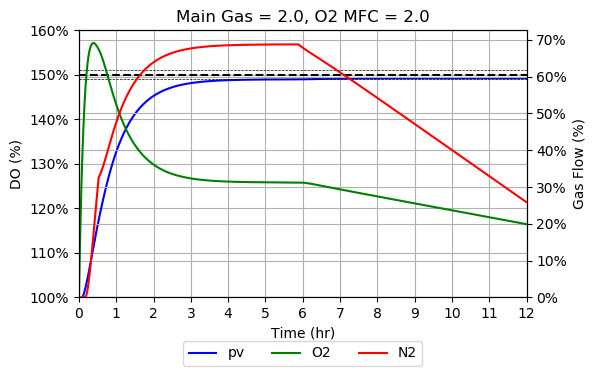

In [12]:
setup2()

ops.mode = "o2a"
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = ops.initial_request_cno
ops.set_point = 150
ops.initial_pv = 100
ops.end = 12*hours

ops.c = 0
ops.dc = 0

ops.main_gas = 2.0
ops.mfcs.o2_max = 2.0

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(100, 160)
a,b = ax2.set_ylim()
ax2.set_ylim(0, b)
ax1.set_title("Main Gas = %.1f, O2 MFC = %.1f"%(ops.main_gas, ops.mfcs.o2_max))

fig

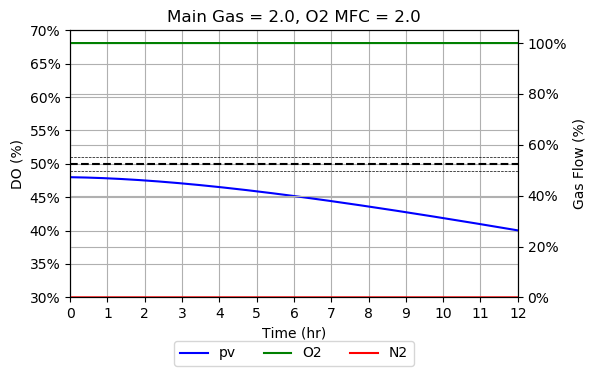

In [87]:
setup2()

ops.set_point = 100
ops.initial_pv = 50

run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(45, 100)
a,b = ax2.set_ylim()
ax2.set_ylim(0, b)
ax1.set_title("Main Gas = %.1f, O2 MFC = %.1f"%(ops.main_gas, ops.mfcs.o2_max))

fig

### Graph generation for Results report for 100% to 150% ramp

In [18]:
ops.set_point = 150
ops.mfcs.o2_max = 2
x, pv, n2, o2 = test3(ops)
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
f = FuncFormatter(lambda y, _: "%.1f%%"%(y*100))
l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax2.yaxis.set_major_formatter(f)
ax.plot(x,pv, "blue", ls="-", label="PV")
ax2.plot(x,o2, "green", ls="-", label="O2 Flow")
ax2.plot(x,n2, "red", ls="-", label="N2 Flow")
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax2.yaxis.set_label_text("Gas Flow Request (%)")
ax.grid()
ax.set_ylim(100, 160)
ax2.set_ylim(0, .80)
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h1.extend(h2)
l1.extend(l2)
ax.legend(h1, l1, loc="center", ncol=3, bbox_to_anchor=(0.5, -.15))
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))
ax2.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))

### Comparison of effect of Main Gas on controller performance

In [26]:
ops.set_point = 150
plt.close()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax.grid()
ax.set_ylim(100, 160)
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
for mg in (0.1, 0.5, 1.0, 2.0):
    ops.main_gas = mg
    x, pv, n2, o2 = test3(ops)
    ax.plot(x,pv, label="%.1f LPM"%mg)
    
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))
ax.legend(loc="center", ncol=4, bbox_to_anchor=(0.5, -.15))

In [25]:
ops.set_point = 150

plt.close()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

l = MultipleLocator(2)
ax.xaxis.set_major_locator(l)
ax.xaxis.set_label_text("Time(hr)")
ax.yaxis.set_label_text("DOPV(%)")
ax.grid()
ax.set_ylim(100, 160)
fig.text(0.15, 0.96, get_text(ops), transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ops.reactor_volume = 11
ops.main_gas = 2
x, pv, n2, o2 = test3(ops)
ax.plot(x,pv, label="2 LPM")
    
ops.reactor_volume = 13
ops.main_gas = mg = 1
x, pv, n2, o2 = test3(ops)
ax.plot(x,pv, label="1 LPM")
    
b = ax.get_position()
ax.set_position((b.x0, b.y0+0.05, b.width,b.height*0.9))
ax.legend(loc="center", ncol=4, bbox_to_anchor=(0.5, -.15))

In [22]:
ax_list1 = []
fig = None

def axes():
    return ax_list1

def setup1(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    global ax_list1
    
    if not plt.get_fignums() or new or not fig:
        fig = plt.figure()
        ax1 = fig.add_subplot(3,1,1)
        ax2 = fig.add_subplot(3,1,2)
        ax3 = fig.add_subplot(3,1,3)
        for a in ax1, ax2, ax3:
            b = a.get_position()
            a.set_position([b.x0, b.y0, b.width*0.9, b.height])
            a.grid()
        ax_list1 = [ax1, ax2, ax3]
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__
    
def test1(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_, o2a = np_unpack(d1)
    return x,pv, n2, o2, o2a*100/0.21

def _p1(ax, x, y, color, label, ylabel=None):
    ax.plot(x,y, color=color, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)

def plot1(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    _p1(ax3, x, pv, "blue", "pv", "DO (%)")
    _p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        a.legend(bbox_to_anchor=(0.99, 1.06), loc="upper left")
    
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish1():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
    
def run1(ops):
    x, pv, n2, o2, o2a = test1(ops)
    plot1(x, pv, n2, o2, o2a)
    finish1()

### 3L Tuning (Final!)

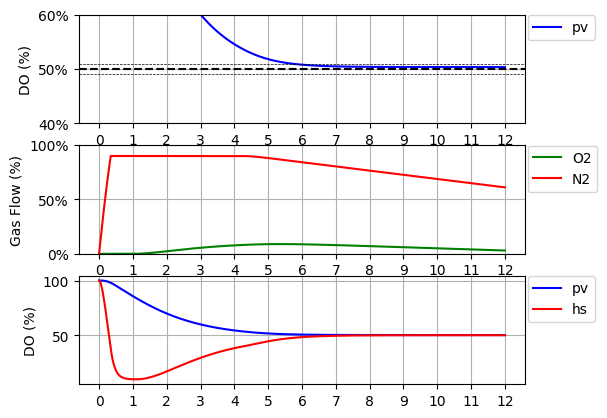

In [26]:
setup1()
ops.set_point = 50
ops.initial_pv = 100
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)

ops.o2_pid.p = 1.5
ops.o2_pid.i = 120

ops.n2_pid.p = -5
ops.n2_pid.i = 50
ops.k_mult = 1
run1(ops)
ax1.set_ylim(40, 60)
ax2.set_ylim(0, 1)
fig

### 3L Graphs for Report

#### Export figures, aggressive

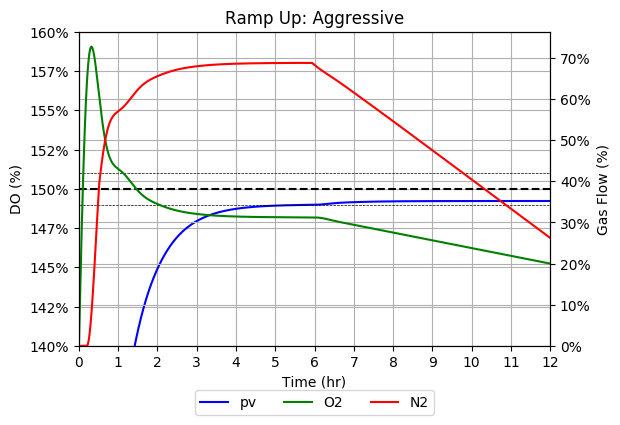

In [30]:
setup2()
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)
ops.set_point = 150
ops.initial_pv = 100
ops.end = 12*hours

# Aggressive
ops.o2_pid.p = 7
ops.o2_pid.i = 50
ops.n2_pid.p = -6
ops.n2_pid.i = 90

# Slower
# ops.o2_pid.p = 1.5
# ops.o2_pid.i = 120
# ops.n2_pid.p = -5
# ops.n2_pid.i = 50

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(140, 160)
a,b = ax2.set_ylim()
ax2.set_ylim(0, b)
ax1.set_title("Ramp Up: Aggressive")
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
#fig.savefig(path+"\\3L ramp up aggressive 170719.png")

fig

#### More tuning.....

In [48]:
def rampup(ops, x, y):
    setup2(True)
    data = rampup2(ops)
    finish_rampup(data, x, y)
    
def finish_rampup(data, x, y):
    run4(*data)
    ax1.set_xlim(0, 12)
    ax1.set_ylim(140, 160)
    ax2.set_ylim(0, 1)
    a,b = ax2.set_ylim()
    ax2.set_ylim(0, b)
    ax1.set_title("Ramp Up: Gradual")
    w=fig.canvas._tkcanvas.master
    w.geometry('565x433+%d+%d'%(x,y))
    
def rampdown(ops, x, y):
    setup2(True)
    data = rampdown2(ops)
    finish_rampdown(data, x, y)
    
def finish_rampdown(data, x, y):
    run4(*data)
    ax1.set_xlim(0, 12)
    ax1.set_ylim(40, 60)
    ax2.set_ylim(0, 1)
    ax1.set_title("Ramp Down: Gradual")
    w=fig.canvas._tkcanvas.master
    w.geometry('565x433+%d+%d'%(x,y))
    
def rampup2(ops):
    ops.set_point = 150
    ops.initial_pv = 100
    return test2(ops)
    
def rampdown2(ops):
    ops.set_point = 50
    ops.initial_pv = 100
    return test2(ops)
    
def run4(x, pv, n2, o2, o2a):
    plot2(x, pv, n2, o2, o2a)
    finish2()
    return

def plot3(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    #_p1(ax3, x, pv, "blue", "pv", "DO (%)")
    #_p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()

In [49]:
# Balanced?
for i in range(100): plt.close()
ops.o2_pid.p = 4
ops.o2_pid.i = 70
ops.n2_pid.p = -5
ops.n2_pid.i = 50

rampup(ops, 1932, 0)
rampdown(ops, 2502, 0)

ops.o2_pid.p = 4
ops.o2_pid.i = 60
ops.n2_pid.p = -5
ops.n2_pid.i = 50

rampup(ops, 1932, 500)
rampdown(ops, 2502, 500)

### 3L Simulation Window

In [89]:
ops = SimOps()
ops.o2_pid.p = 2
ops.o2_pid.i = 40
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -5
ops.n2_pid.i = 40
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = .1
ops.mfcs.o2_max = .5
ops.mfcs.n2_max = .5
ops.mfcs.air_max = .5

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 5*hours
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 100
ops.set_point = 50
ops.set_point_deadband = 1
ops.k_mult = 1
ops.k = k_3L
ops.c = None
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 0.2
ops.reactor_size = 3
ops.volume = 2.5
ops.time_unit = hours
ops.max_iters = 3 * days

ops.o2_pid.p = 1.5
ops.o2_pid.i = 150

ops.n2_pid.p = -3
ops.n2_pid.i = 50

In [90]:
cfg = SimConfig()
cfg.simops = ops
def run4():
    global root, f
    cfg.simops.o2_pid.p = 1.5
    cfg.simops.o2_pid.i = 150
    cfg.simops.o2_pid.amax = 100
    cfg.simops.o2_pid.deadband = 0
    cfg.simops.o2_pid.beta = 0
    cfg.simops.o2_pid.man_request = 10

    cfg.simops.n2_pid.p = -3
    cfg.simops.n2_pid.i = 50
    cfg.simops.n2_pid.amax = 90
    cfg.simops.n2_pid.deadband = 0
    cfg.simops.n2_pid.beta = 0
    cfg.simops.n2_pid.man_request = 10
    cfg.simops.delay=0*minutes

    cfg.update_interval = 50
    cfg.time_factor = 200

    cfg.simops.initial_pv = 100
    cfg.simops.set_point = 100

    cfg.xwindow_hrs = 10

    root = TkQuitHack()
    root.wm_title("DO Simulation")
    #root.geometry("%dx%d"%(600, 800))
    f = PIDSimFrame(root, cfg)
    f.pack()
    root.mainloop()

In [91]:
run4()

AttributeError: 'FigureCanvasTkAgg' object has no attribute 'show'